In [10]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
import cv2
from tensorflow.keras import layers, Sequential, datasets, Model
import warnings
warnings.filterwarnings('ignore')


In [11]:
dir_path = r"archive/img_align_celeba/img_align_celeba"
def load_images(folder_path, img_size = (128, 128)):
    X = []
    limit = 50000
    for img_name in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        img_array = cv2.imread(img_path)
        img_array = cv2.resize(img_array, img_size)
        img_array = img_array[:,:,::-1]
        X.append(img_array / 255.0)
        if len(X) >= limit:
            break
    return np.array(X)

img_size = 64
X_train = load_images(dir_path, (img_size, img_size))
X_train.shape

 25%|██▍       | 49999/202599 [04:52<14:53, 170.79it/s]


(50000, 64, 64, 3)

In [12]:
fixed_noise = tf.random.normal((60, 128))

2024-05-01 18:35:02.388958: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 18:35:02.402499: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 18:35:02.402598: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

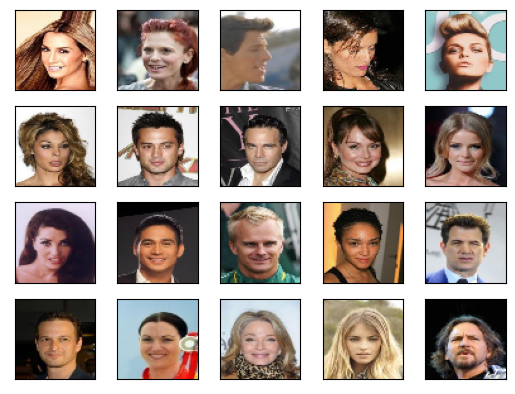

In [15]:
def show_images(images):
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()
show_images(X_train)

In [16]:
Discriminator = Sequential([
    layers.Conv2D(256, kernel_size = (3, 3), strides = 2, padding = 'same', input_shape = (64, 64, 3)),
    layers.LeakyReLU(),

    layers.Conv2D(128, kernel_size = (3, 3), strides = 2, padding = 'same'),
    layers.LeakyReLU(),
    layers.BatchNormalization(),

    layers.Conv2D(64, kernel_size = (3, 3), strides = 2, padding = 'same'),
    layers.LeakyReLU(),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(1)
])

In [17]:
Generator = Sequential([
    layers.Dense(8 * 8 * 128, input_shape = (128,)),
    layers.BatchNormalization(),

    layers.Reshape((8, 8, 128)),
    layers.Conv2DTranspose(256, kernel_size = (3, 3), strides = 2, padding = 'same'),
    layers.LeakyReLU(),
    layers.BatchNormalization(),

    layers.Conv2DTranspose(128, kernel_size = (3, 3), strides = 2, padding = 'same'),
    layers.LeakyReLU(),
    layers.BatchNormalization(),


    layers.Conv2DTranspose(3, kernel_size = (3, 3), strides = 2, padding = 'same', activation = 'sigmoid'),
])

In [18]:
class GAN(Model):
    def __init__(self, Generator, Discriminator):
        super().__init__()
        self.latent_dim = 128
        self.generator = Generator
        self.discriminator = Discriminator
        # print(self.generator.model.summary())
    def compile(self, gen_optimizer, disc_optimizer, criterion):
        super().compile()
        self.generator_optimizer = gen_optimizer
        self.discriminator_optimizer = disc_optimizer
        self.cross_entropy = criterion

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss


    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def train_step(self, images):
        
        noise = tf.random.normal([images.shape[0], self.latent_dim])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return {"Generator Loss": gen_loss, "Discriminator Loss": disc_loss}

In [19]:
model = GAN(Generator, Discriminator)
model.compile(gen_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              disc_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              criterion = tf.keras.losses.BinaryCrossentropy(True))

In [25]:
model.fit(X_train, epochs = 100, batch_size = 5)

2024-05-01 19:52:31.333029: W external/local_tsl/tsl/framework/bfc_allocator.cc:487] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB (rounded to 2457600000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-05-01 19:52:31.333060: I external/local_tsl/tsl/framework/bfc_allocator.cc:1044] BFCAllocator dump for GPU_0_bfc
2024-05-01 19:52:31.333068: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (256): 	Total Chunks: 29, Chunks in use: 29. 7.2KiB allocated for chunks. 7.2KiB in use in bin. 1.4KiB client-requested in use in bin.
2024-05-01 19:52:31.333073: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (512): 	Total Chunks: 10, Chunks in use: 10. 5.0KiB allocated for chunks. 5.0KiB in use in bin. 5.0KiB client-requested in use in bin.
2024-05-01 19:52:31.333

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

n use: 3. 103.0KiB allocated for chunks. 76.8KiB in use in bin. 73.0KiB client-requested in use in bin.
2024-05-01 19:52:31.333099: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (32768): 	Total Chunks: 5, Chunks in use: 5. 160.0KiB allocated for chunks. 160.0KiB in use in bin. 160.0KiB client-requested in use in bin.
2024-05-01 19:52:31.333102: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (65536): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-05-01 19:52:31.333106: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (131072): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-05-01 19:52:31.333109: I external/local_tsl/tsl/framework/bfc_allocator.cc:1051] Bin (262144): 	Total Chunks: 2, Chunks in use: 1. 686.8KiB allocated for chunks. 288.0KiB in use in bin. 288.0KiB client-requested in use in bin.
2024-0

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step


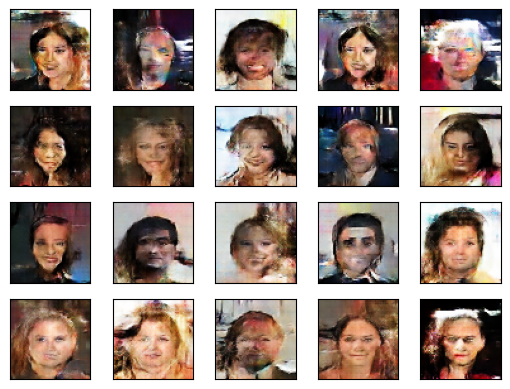

In [ ]:
y_pred = model.generator.predict(fixed_noise)
show_images(y_pred)